**# DATA ANALYSIS**

1. Organise the data
2. Pass log files with and witghout MAC verification to extract releventy fields such as:
    * Timestamps
    * CAN ID
    * Data
    * Origin
    * Destination
    * Status
    * Error
    * Latency

3. Data points of interest
  *  Latency: Time difference between messages sent and received
  *  Messages Type: Whether the message triggered a sensor or system action (Belt ON/OFF, Headlights ON/OFF, Door Locked/Unlocked)
  *  MAC Verification : Whether the messages passed or failed MAC verification in the log file with MAC
  * Errors: Number abnormal messages messages (invalid CAN IDs, failed MAC checks)

4. Descriptive Statistics:
  * Mean, Median and Standard Deviation: Compute these for both log files with MAC and without MAC to compare the overhead introduced by the MAC vefication
  * Success and Failure Rate: For the MAC-Enabled log, calculate the percentage of messages that successfully passed the MAC verification versus those that failed
  * Error Rate: For log wihout MAC caculate how many messages were flagged as abnormal due to invalid CAN ID and comapre to the toatl number of messages

5. Visualization
  * Latency Comparisoon :
      * X-Axis - Timestamp
      * Y axis Latency in milliseconds
      * Plot latency distribution for each condition with and without MAC

    * MAC verification Analysis:

      Create a pie chart showing the proportion of messages that passed MAC verification (Belt ON/OFF, Headlights ON/OFF, Door Locked/Unlocked)
    
    * Message Types Breakdown

      A bar graph to show the proportion of different messages types (Belt ON/OFF, Headlights ON/OFF, Door Locked/Unlocked) processed in each log

6. Error and Abnormal Messages Analysis:
  * For each fuzzing attack (Random, Linear, Brute Force, Mutated Based and Replay) test calculate how many abnormal or authorized messgaes were proccesssed with or without MAC enabled

  * Error Rate Comaprison; Plot a graph showing error rate (invlaid CAN IDs or failed MAC verication) between the logs.

To access the google drive files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Import libraries**

In [ ]:
import re
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

**# Parse the log file to extract relevent information:**
* Timestamps
* CAN ID
* Data
* Origin
* Destination
* Status
* Error
* Latency

***For example:***

```
2024-09-24 14:23:14,763 CAN ID:512
Data:bytearray(b'\x03f\xf2\xbdBs\xda\xb8')
Origin:DCM
Destination:BCM
Status:Door is Locked
Error:MAC verification successful
Latency:763
```






In [ ]:
# Function to parse CAN message log lines
def parse_can_message(lines):
    message = {}

    # Extract the first line (timestamp and CAN ID)
    timestamp_match = re.search(r'^(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) CAN ID:(\d+)', lines[0])
    if timestamp_match:
        message['Timestamp'] = datetime.strptime(timestamp_match.group(1), '%Y-%m-%d %H:%M:%S,%f')
        message['CAN_ID'] = int(timestamp_match.group(2))

    # Extract Data
    data_match = re.search(r"Data:bytearray\((.*)\)", lines[1])
    if data_match:
        message['Data'] = data_match.group(1)

    # Extract Origin, Destination, Diagnostic Message, and Latency
    message['Origin'] = lines[2].split(':')[1].strip()
    message['Destination'] = lines[3].split(':')[1].strip()
    message['Status'] = lines[4].split(':')[1].strip()
    message['Error'] = lines[5].split(':')[1].strip()

    # Extract and handle Latency (convert 'N/A' to 0)
    latency_value = lines[6].split(':')[1].strip()
    if latency_value == 'N/A':
        message['Latency'] = 0
    else:
        message['Latency'] = int(latency_value)

    # message['Latency'] = int(lines[6].split(':')[1].strip())

    return message

# **Visualise Latency over time**

In [ ]:
def Latency_over_time(df):
  plt.figure(figsize=(10, 6))
  plt.plot(df['Timestamp'], df['Latency'], marker='o', linestyle='-', color='blue')
  plt.xlabel('Timestamp')
  plt.ylabel('Latency (ms)')
  plt.title('Latency Over Time')
  plt.xticks(rotation=45)
  plt.grid(True)
  plt.show()

# **Visualise Latency distribution**




In [ ]:
def Latency_distribution(df):
    latency_summary = df['Latency'].describe()
    print('\nLatency Distribution:\n', latency_summary)

    # Visualize: Latency distribution using histogram with a normal distribution curve
    plt.figure(figsize=(10, 6))

    # Create a histogram of the latency values
    sns.histplot(df['Latency'], kde=True, color='blue', bins=10)

    # Label the plot
    plt.ylabel('Frequency')
    plt.xlabel('Latency (ms)')
    plt.title('Latency Distribution with Normal Curve')

    plt.show()


# **Display Message Distribution**

In [ ]:
def Message_distribution(df):
  message_counts = df['Status'].value_counts()
  print('Sensor Status Distribution:\n',message_counts)

  plt.figure(figsize=(10, 6))
  message_counts.plot(kind='bar', color='blue')
  plt.xlabel('Status')
  plt.ylabel('Count')
  plt.title('Sensor Status Distribution')
  plt.xticks(rotation=45)
  plt.show()

# **Dispaly Errors Distribution**

In [ ]:
def Error_distribution(df):
  error_counts = df['Error'].value_counts()
  print('Error Distribution:\n',error_counts)

  # Plot the pie chart
  plt.figure(figsize=(8, 8))
  plt.pie(error_counts, labels=error_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen', 'lightcoral', 'yellow'])

  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.axis('equal')

  # Add a title
  plt.title('Error Distribution in CAN Messages')
  plt.show()

# Read Captured CAN Messages

In [ ]:
!pip install python-can

In [ ]:
import pickle
import pprint

obj = pickle.load(open("ECU2/captured_frames.pkl", "rb"))

with open("ECU2/out.txt", "a") as f:
  print(f"Loaded {len(obj)} captured frames from captured_frames.pkl", file=f)
  print('!')
  pprint.pprint(obj, stream=f)

!


# **Extraxt Statics Data**

                Timestamp  CAN_ID                                 Data Origin  \
0 2024-09-26 13:28:45.869     256  b'\x00\x00\x00\x00\x00\x00\x83\x90'    BSM   
1 2024-09-26 13:28:45.870     256  b'\x00\x00\x00\x00\x00\x00\x83\x91'    BSM   
2 2024-09-26 13:28:45.872     256  b'\x00\x00\x00\x00\x00\x00\x83\x92'    BSM   
3 2024-09-26 13:28:45.873     256  b'\x00\x00\x00\x00\x00\x00\x83\x93'    BSM   
4 2024-09-26 13:28:45.875     256  b'\x00\x00\x00\x00\x00\x00\x83\x94'    BSM   

  Destination Status Error        Latency  
0         BCM   None  None  1727353725869  
1         BCM   None  None  1727353725870  
2         BCM   None  None  1727353725872  
3         BCM   None  None  1727353725873  
4         BCM   None  None  1727353725875  


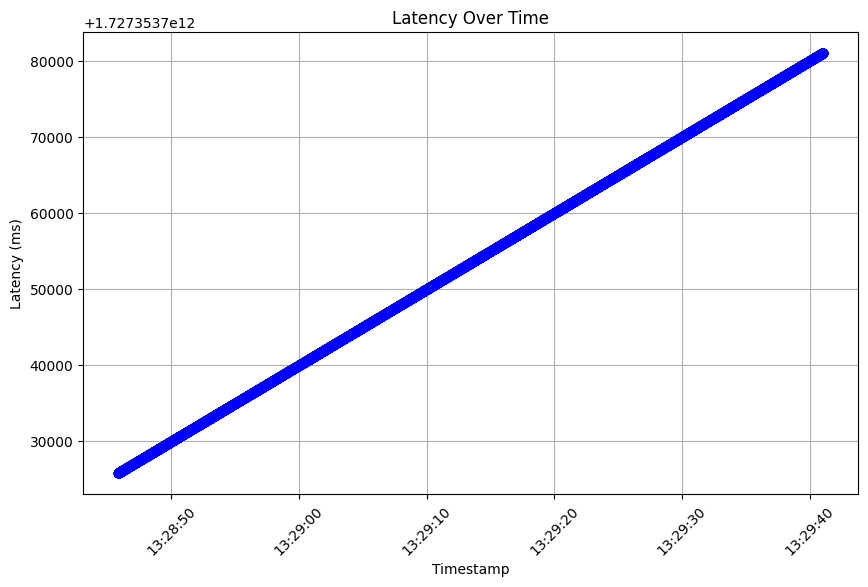


Latency Distribution:
 count    3.320800e+04
mean     1.727354e+12
std      1.597150e+04
min      1.727354e+12
25%      1.727354e+12
50%      1.727354e+12
75%      1.727354e+12
max      1.727354e+12
Name: Latency, dtype: float64


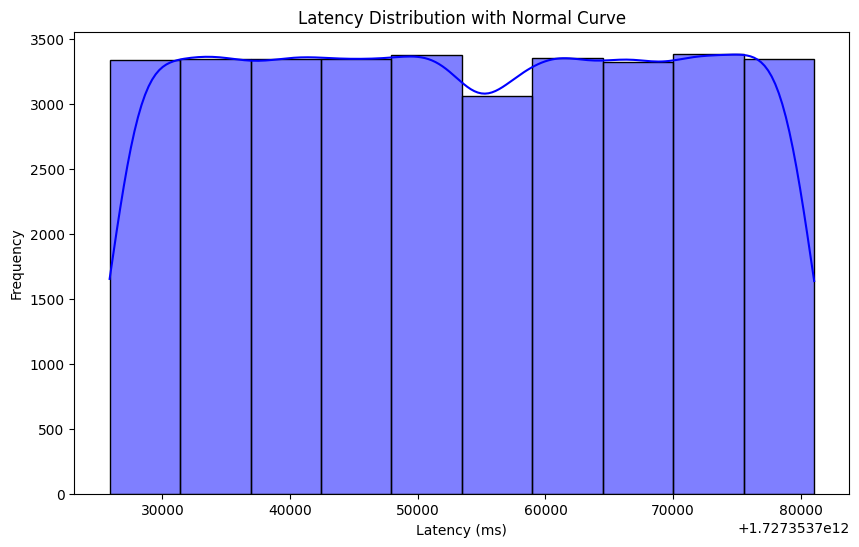

Sensor Status Distribution:
 Status
None    33208
Name: count, dtype: int64


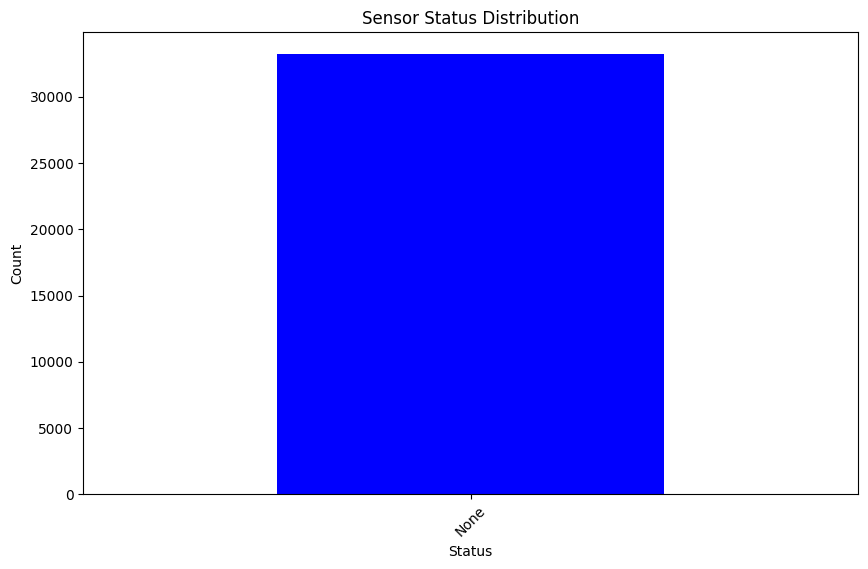

Error Distribution:
 Error
None    33208
Name: count, dtype: int64


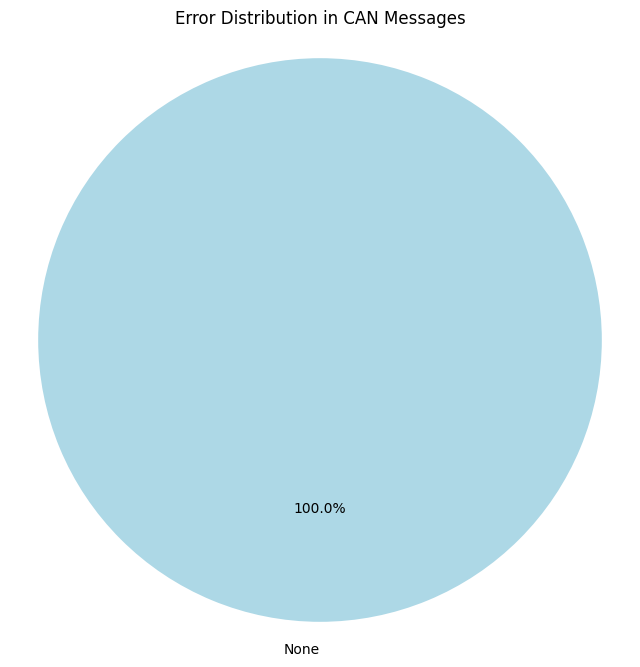

In [ ]:
filename='ECU2/BCM.log'

with open(filename, 'r') as file:
        log_data = file.readlines()[1:]

 #List to store parsed CAN messages
can_messages = []
# Parse the log file line by line
i = 0
while i < len(log_data):
    # Check if the line contains a CAN message (timestamp followed by CAN ID)
    if "CAN ID" in log_data[i]:
        # Each CAN message is followed by 6 additional lines
        can_message = parse_can_message(log_data[i:i+7])
        can_messages.append(can_message)
        i += 7  # Skip to the next message
    else:
        i += 1  # Skip non-CAN log lines

# Create a pandas DataFrame from the extracted data
df = pd.DataFrame(can_messages)

# Display the first few rows
print(df.head())

# Display latency over time
Latency_over_time(df)

# display latency distribution
Latency_distribution(df)

# display message distribution
Message_distribution(df)

# display errors distribution
Error_distribution(df)